# Subsampling approaches to MCMC for tall data - Gamma distribution

Marine Robinson, Matthieu Sommervogel

**Table of contents**    
1. [Generate toy data](#Generate-toy-data)  
2. [Wind speed data](#Wind-speed-data)
3. [Vanilla MH on toy data](#Vanilla-MH-on-toy-data)
4. [Confidence sampler with proxy](#Confidence-MH-with-2nd-order-Taylor-likelihood-proxy)
5. [Vanilla MH on wind speed data](#Vanilla-MH-on-wind-speed-data)

In [1]:
%pylab inline
figsize(10,5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [18]:
saveDirStr = ""

In [2]:
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import scipy.special as spsp
import scipy.misc as spm
import scipy.optimize as spo
import numpy.linalg as npl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sympy as sym
import time
import seaborn as sns
import seaborn.distributions as snsd
import math as math
from scipy.special import logsumexp
import pandas as pd
from math import gamma as g
from os import listdir
from os.path import isfile, join
npr.seed(1)
sns.set(style="ticks")

# Generate toy data

In [3]:
def gamma(x,k, theta):
    return x**(k-1)*np.exp(-x/theta)/(g(k)*theta**k)

In [4]:
npr.seed(1)
N = 100000
k = 1.5
t = 2.5
x1 = npr.gamma(k, t, size=N)
realMean = np.mean(x1)
realStd = np.std(x1)

Mean of x = 3.763386046639891
Std of x = 3.0732627525745424


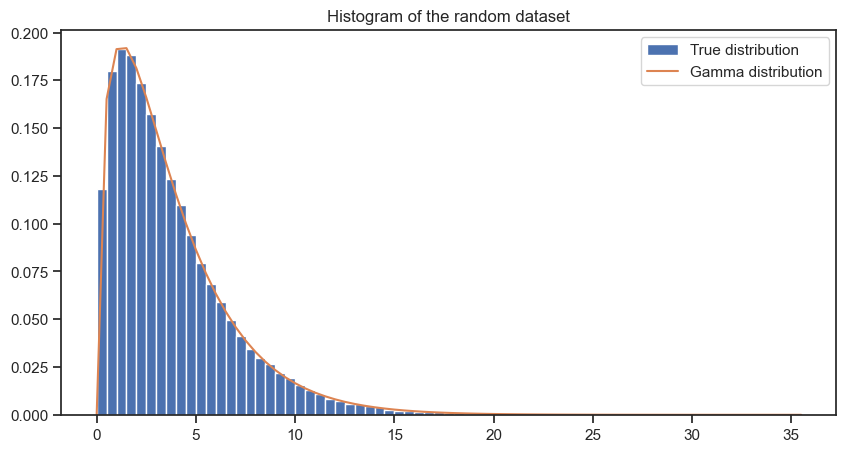

In [6]:
from math import gamma as g
print("Mean of x =", realMean)
print("Std of x =", realStd)
x_plot = np.arange(0, max(x1), 0.5)
y_plot = gamma(x_plot, k, t)
plt.hist(x1, bins = np.arange(min(x1), max(x1), 0.5), density = True, label = 'True distribution')
plt.plot(x_plot, y_plot, label = "Gamma distribution")
plt.legend()
plt.title("Histogram of the random dataset")
plt.show()

# Wind speed data

In [7]:
def estimateParams(x):
    theta = x.std()**2/x.mean()
    k = x.mean()/theta
    return theta, k

In [8]:
fichiers = [f for f in listdir('donnees_meteo') if isfile(join('donnees_meteo', f))]
big_df = pd.read_csv('donnees_meteo/synop.202106.csv', sep = ';')
for f in fichiers:
    df = pd.read_csv('donnees_meteo/{}'.format(f), sep = ';')
    big_df = pd.concat([big_df, df], ignore_index=True, sort=False)
big_df2 = big_df[big_df['ff']!='mq']
big_df2.loc[:,'ff'] = big_df2['ff'].astype(float)
x2 = np.array(big_df2['ff'])
eps = 1e-5
x2 = x2 + eps
min_ff = min(x2)
max_ff = max(x2)

C:\Users\mrobi\AppData\Local\Temp\ipykernel_14172\1088993382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_df2.loc[:,'ff'] = big_df2['ff'].astype(float)


Mean of x = 4.044647595757217
Std of x = 3.1442099669576593


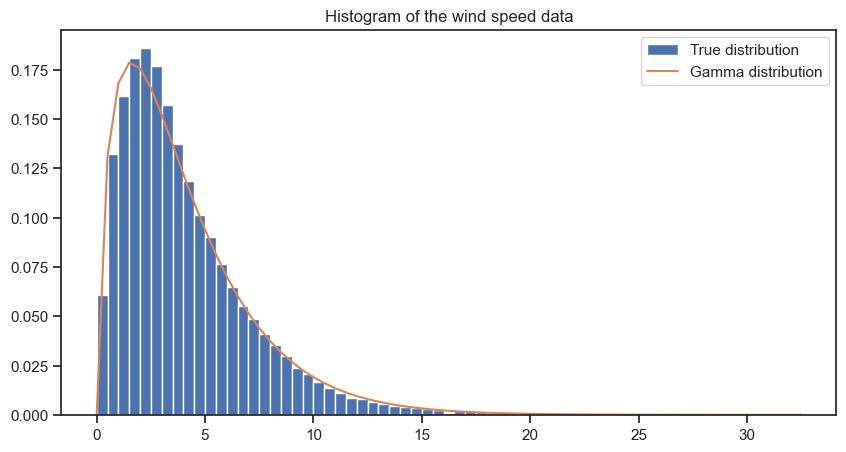

In [10]:
from math import gamma as g
realMean = np.mean(x2)
realStd = np.std(x2)
print("Mean of x =", realMean)
print("Std of x =", realStd)
theta, k = estimateParams(x2)
x_plot = np.arange(0, max_ff, 0.5)
y_plot = gamma(x_plot, k, theta)
plt.hist(x2, bins = np.arange(min_ff, max_ff, 0.5), density = True, label = 'True distribution')
plt.plot(x_plot, y_plot, label = "Gamma distribution")
plt.legend()
plt.title("Histogram of the wind speed data")
plt.show()


#  Vanilla MH on toy data

In [11]:
from math import gamma as g

def getLogLhdGamma(x, k, theta):
    return (k-1)*np.log(x) - x/theta - np.log(g(k)) - k*np.log(theta)

In [21]:
def plotResults(S, ns, algoName="doesNotMatter", weights="doesNotMatter", boolSave=0, figId="basic"):
    """
    plot results
    """    
    # Plot joint sample with seaborn
    m = np.min(S[:,0]) # Precompute limits for x and y plots
    M = np.max(S[:,0])
    m_ref = np.min(S_ref[:,0]) # Precompute limits for x and y plots
    M_ref = np.max(S_ref[:,0])
    
    xlimInf = min(m, m_ref)# - (M-m)/10
    xlimSup = max(M, M_ref)# +(M-m)/10
    print("xlims =", xlimInf, xlimSup) # +(M-m)/10
    xPlot = np.linspace(xlimInf, xlimSup, 1000)
    m = np.min(S[:,1])
    M = np.max(S[:,1])
    m_ref = np.min(S_ref[:,1]) # Precompute limits for x and y plots
    M_ref = np.max(S_ref[:,1])
    ylimInf = min(m, m_ref)# - (M-m)/10
    ylimSup = max(M, M_ref)
    yPlot = np.linspace(ylimInf, ylimSup, 1000)
    
    if algoName == "sgld":
        # Need to convert a weighted sample into a unweighted sample
        sumWeights = np.sum(weights)
        normalizedWeights = weights/sumWeights
        T = S.shape[0]
        inds = npr.choice(np.arange(T), T, p=normalizedWeights)
        S = S[inds,:]
    
    g = sns.jointplot(S[:,0], S[:,1], kind="hex", space=0,size=10, xlim=(xlimInf,xlimSup), ylim=(ylimInf,ylimSup), marginal_kws=dict(stat='density')) # 
    plt.sca(g.ax_joint)
    plt.xlabel("k",)
    plt.ylabel("$\Theta$")
    
    # Add Reference long MH draw 
    # ... to the joint plot
    sns.kdeplot(S_ref[:,0], S_ref[:,1], ax=g.ax_joint, bw="silverman", cmap="BuGn_r", linewidth=5)
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, marg0(xPlot), 'g', linewidth=6, label="Ref")
    g.ax_marg_y.plot(marg1(yPlot), yPlot, 'g', linewidth=6)
    
    # Add Bernstein von Mises approximations
    # ... to the joint plot
    #X, Y = np.meshgrid(xPlot, yPlot)
    #minusFisher = np.array([[1./realStd**2, 0],[0, 2./realStd**2]])
    #SS = 1./N*npl.inv(minusFisher)
    #Z = bivariate_normal(X, Y, sigmax=np.sqrt(SS[0,0]), mux=realMean, muy=realStd, sigmay=np.sqrt(SS[1,1]), sigmaxy=np.sqrt(SS[0,1])) # Plot BvM approximation
    #g.ax_joint.contour(X, Y, -Z, 1, colors="r", label="BvM", linestyle='--',linewidths=(6))
    # ... to the marginal plots
    #g.ax_marg_x.plot(xPlot, sps.norm(realMean, np.sqrt(SS[0,0])).pdf(xPlot), color="red", linewidth=6, linestyle='--', label="BvM")
    #g.ax_marg_y.plot(sps.norm(realStd, np.sqrt(SS[1,1])).pdf(yPlot), yPlot, color="red", linewidth=6, linestyle='--')
    
    # Print legend and save
    
    g.ax_marg_x.legend()
    print(saveDirStr+"chain_"+algoName+"_"+figId+".pdf")
    plt.savefig(saveDirStr+"chain_"+algoName+"_"+figId+".pdf")
      
    if boolSave:
        plt.savefig(saveDirStr+"chain_"+algoName+"_"+figId+".pdf")
        plt.savefig(saveDirStr+"chain_"+algoName+"_"+figId+".eps")
    plt.show()    
        
    # Plot autocorr of second component
    c = plt.acorr(S[:,1], maxlags=50, detrend=detrend_mean, normed=True)
    plt.clf()
    c = c[1][c[0]>=0]
    plt.plot(c, linewidth=3)
    plt.plot(c_ref, label="Ref", linewidth=3, color="g")
    plt.grid(True)
    
    plt.legend(loc=1)
    if boolSave:
            plt.savefig(saveDirStr+"autocorr_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"autocorr_"+algoName+"_"+figId+".eps")
 
    plt.show()
      
    # Plot average number of likelihoods computed
    if not algoName =="vanillaMH":
        plt.hist(ns, histtype="stepfilled", alpha=.3)
        labStr = "mean="+str(np.around(1.0*np.mean(ns)/N*100,1))+"\%"
        plt.axvline(np.mean(ns), linewidth = 4, color="blue", label=labStr)
        labStr = "median="+str(np.around(1.0*np.median(ns)/N*100,1))+"\%"
        print("Median=", np.median(ns))
        plt.axvline(np.median(ns), linewidth = 4, color="blue",linestyle='--', label=labStr)
        plt.axvline(N, linewidth = 4, color="k", label="n") 
        plt.xlim([0, 2*N+1])
        plt.legend()
        if boolSave:
            plt.savefig(saveDirStr+"numLhdEvals_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"numLhdEvals_"+algoName+"_"+figId+".eps")
            print("Plots saved")
        plt.show()

In [13]:
def vanillaMHGamma(T):
    """
    perform traditional isotropic random walk Metropolis
    """
    theta = np.array([realMean**2/realStd**2,realStd**2/realMean])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0
    
    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhdGamma(x, thetaP[0], thetaP[1]) - getLogLhdGamma(x, theta[0], theta[1])
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            print("Iteration", i, "Acceptance", acceptance)
            
    return S

In [14]:
x = x1

Iteration 0 Acceptance 1.0
Iteration 5000 Acceptance 0.5018996200759838
Iteration 10000 Acceptance 0.5040495950404956
Iteration 15000 Acceptance 0.506099593360445
Iteration 20000 Acceptance 0.5072246387680628
Iteration 25000 Acceptance 0.5048198072077181
Iteration 30000 Acceptance 0.5047498416719476
Iteration 35000 Acceptance 0.5041855946972947
Iteration 40000 Acceptance 0.5043623909402272
Iteration 45000 Acceptance 0.504522121730629


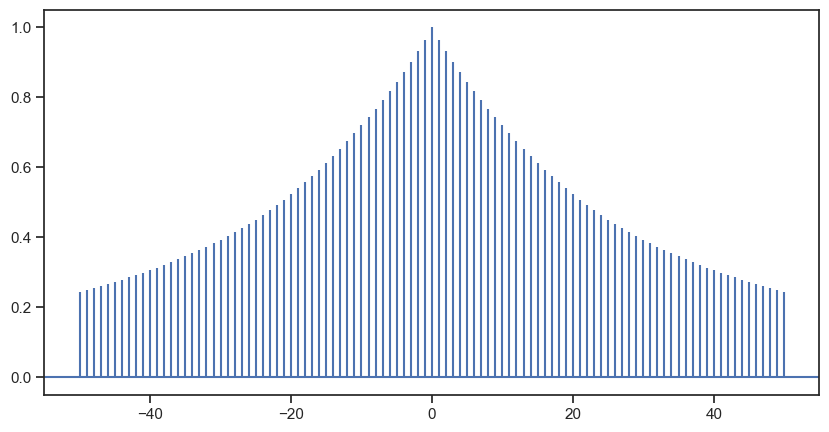

In [15]:
# Compute good marginals using a long run for later comparisons
S_ref = vanillaMHGamma(50000)
marg0 = sps.gaussian_kde(S_ref[:,0])
marg1 = sps.gaussian_kde(S_ref[:,1])
c = plt.acorr(S_ref[:,1], maxlags=50, detrend=detrend_mean, normed=True);
c_ref = c[1][c[0]>=0]
plt.show()

In [16]:
S = vanillaMHGamma(10000)

Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.4985014985014995
Iteration 2000 Acceptance 0.4997501249375308
Iteration 3000 Acceptance 0.5111629456847714
Iteration 4000 Acceptance 0.509372656835791
Iteration 5000 Acceptance 0.51389722055589
Iteration 6000 Acceptance 0.5157473754374278
Iteration 7000 Acceptance 0.5159262962433934
Iteration 8000 Acceptance 0.5134358205224357
Iteration 9000 Acceptance 0.5137206977002557


xlims = 1.4762127571971169 1.6522836622384045


C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjus

chain_vanillaMH_basic.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


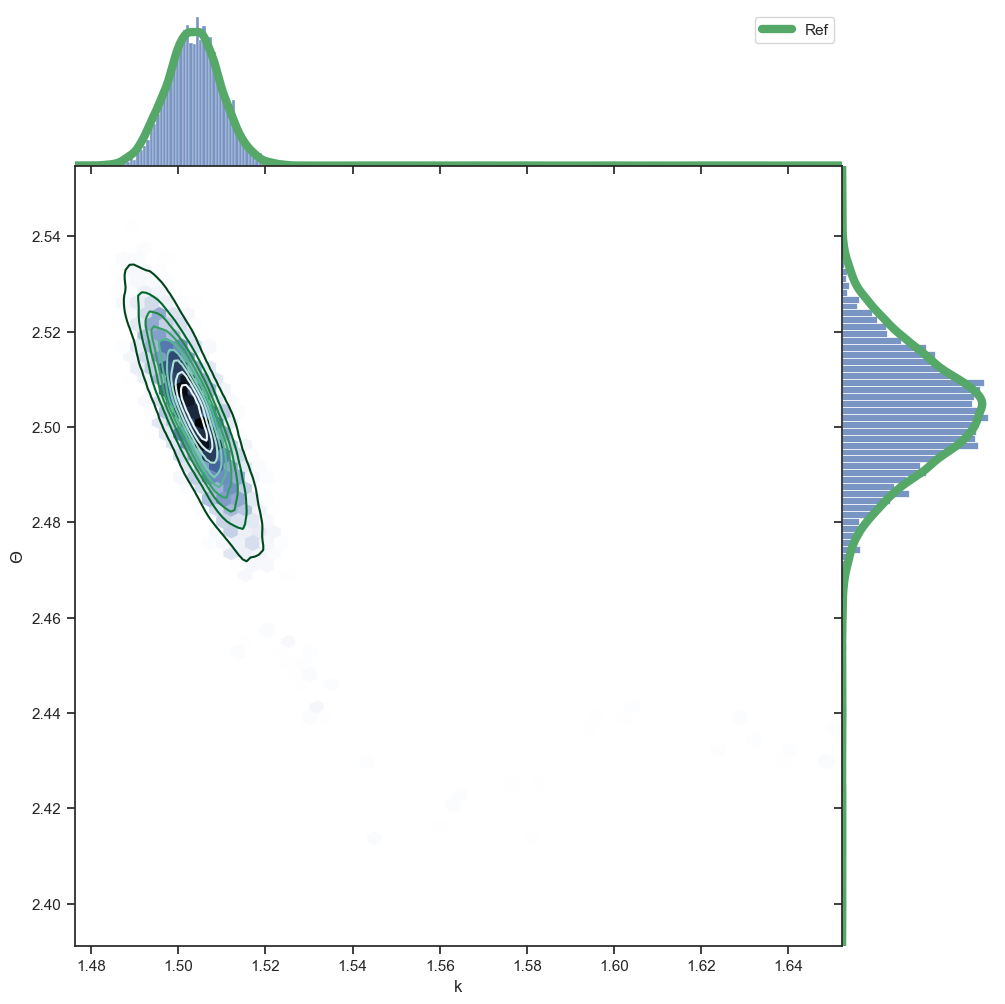

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


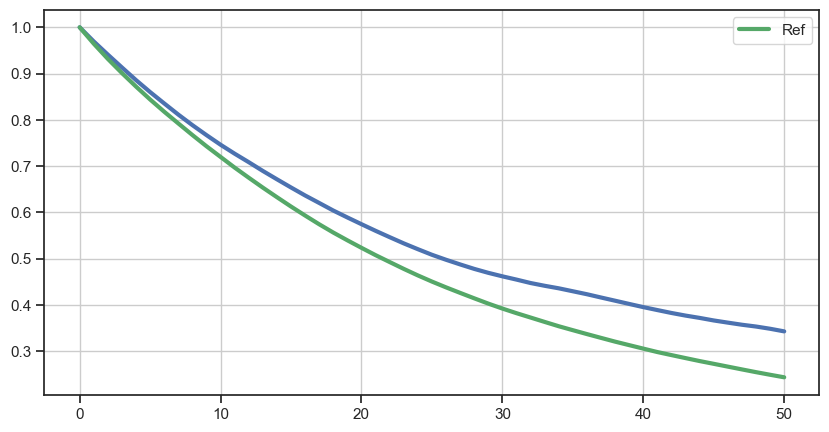

In [22]:
plotResults(S, [], algoName="vanillaMH", boolSave=1)

# Confidence MH with 2nd order Taylor likelihood proxy

In [23]:
def combineMeansAndSSQs(N1, mu1, ssq1, N2, mu2, ssq2):
    """
    combine means and sum of squares of two sets
    """
    dd = mu2 - mu1
    mu = mu1
    ssq = ssq1
    N = N1+N2
    mu += dd*N2/N
    ssq += ssq2
    ssq += (dd**2) * N1 * N2 / N
    return N, mu, ssq
# Concentration bounds
def ctBernsteinSerfling(N,n,a,b,sigma,delta):
    """
    Bernstein-type bound without replacement, from (Bardenet and Maillard, to appear in Bernoulli)
    """
    l5 = np.log(5/delta)
    kappa = 7.0/3+3/np.sqrt(2)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return sigma*np.sqrt(2*rho*l5/n) + kappa*(b-a)*l5/n

def ctHoeffdingSerfling(N,n,a,b,delta):
    """
    Classical Hoeffding-type bound without replacement, from (Serfling, Annals of Stats 1974)
    """
    l2 = np.log(2/delta)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return (b-a)*np.sqrt(rho*l2/2/n)

def ctBernstein(N,n,a,b,sigma,delta):
    """
    Classical Bernstein bound, see e.g. the book by Boucheron, Lugosi, and Massart, 2014.
    """
    l3 = np.log(3/delta)
    return sigma*np.sqrt(2*l3/n) + 3*(b-a)*l3/n

#Function to compute the gradient and evaluate it
def evalGrad(x_float, k_float, t_float):
    y, k, t = sym.symbols('y, k, t')
    L = [0, 0]
    args = [0, 0]
    args[0] = tuple([(k-1)*sym.log(y) - y/t - sym.log(sym.gamma(k)) - k*sym.log(t)] + [t for cpt in range(0)] + [k for cpt in range(1)])
    args[1] = tuple([(k-1)*sym.log(y) - y/t - sym.log(sym.gamma(k)) - k*sym.log(t)] + [t for cpt in range(1)] + [k for cpt in range(0)])
    L[0] = sym.diff(*args[0])
    L[1] = sym.diff(*args[1])
    print(L)
    evalG = [L[i].subs('y',x_float).subs('k',k_float).subs('t',t_float).evalf() for i in range(2)]
    return evalG
#Function to compute the Hessian matrix and evaluate it
def evalHessian(x_float, k_float, t_float):
    y, k, t = sym.symbols('y, k, t')
    L = []
    exp = (k-1)*sym.log(y) - y/t - sym.log(sym.gamma(k)) - k*sym.log(t)
    for i in range(3):
        for j in range(3):
            if i+j ==2:
                args = tuple([exp]+ [k for cpt in range(i)]+ [t for cpt in range(j)])
                L.append(sym.diff(*args))
    L = L[0:2] + L[1:2] + L[2:]
    print(L)
    evalH = [L[i].subs('y',x_float).subs('k',k_float).subs('t',t_float).evalf() for i in range(4)]
    evalH = np.array(evalH)
    evalH = np.reshape(evalH, (2, 2))
    return evalH

myGradientVect = lambda x_float, k_float, t_float:np.array([-np.log(t_float) + np.log(x_float) - spsp.polygamma(0, k_float), - k_float/t_float + x_float/(t_float**2)]).T
myHessianVect = lambda x_float, k_float, t_float:[[(k_float - 2*x_float/t_float)/(t_float**2), -1/t_float ], [-1/t_float,-spsp.polygamma(1, k_float) ]]
            

# Compute third order derivatives to bound the Taylor remainder. Symbolic differentiation is not really necessary in this simple case, but
# it may be useful in later applications
def thirdDerivatives():
    x, k, t = sym.symbols('x, k, t')
    L = []
    for i in range(4):
        for j in range(4):
            if i+j == 3:
                args = tuple([(k-1)*sym.log(x) - x/t - sym.log(sym.gamma(k)) - k*sym.log(t)] + [t for cpt in range(1)] + [k for cpt in range(0)])                
                L.append( sym.diff(*args) )
    return L
    
def evalThirdDerivatives(x_float, k_float, t_float): 
    tt = thirdDerivatives()
    return [tt[i].subs('x',x_float).subs('k',k_float).subs('t',t_float).evalf() for i in range(4)]

# Find the MAP (not really necessary here since the MAP are the mean and std deviation of the data)
f = lambda theta: -np.mean(getLogLhdGamma(x, theta[0], theta[1]))
thetaMAP = spo.minimize(f, np.array([realMean**2/realStd**2,realStd**2/realMean])).x
print("MAP is", thetaMAP, "Real values are " , realMean**2/realStd**2,realStd**2/realMean )
tt = thirdDerivatives()
print(tt)

MAP is [1.50357778 2.50297435] Real values are  1.6547725048729045 2.4442318106245473
[-k/t + x/t**2, -k/t + x/t**2, -k/t + x/t**2, -k/t + x/t**2]


In [24]:
# Confidence MCMC with proxy (Bardenet, Doucet, and Holmes, this submission)
def confidenceMCMCWithProxy(T):
    
    npr.seed(1)
    # Initialize
    theta = np.array([realMean**2/realStd**2,realStd**2/realMean])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute some statistics of the data that will be useful for bounding the error and averaging the proxies    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare total sum of Taylor proxys
    kMAP = thetaMAP[0]
    tMAP = thetaMAP[1]
    meanGradMAP = np.array( [(meanx - kMAP)/tMAP**2, (meanxSquared-2*kMAP*meanx+kMAP**2)/tMAP**3 - 1./tMAP] )
    meanHessMAP = np.array( [[-1./tMAP**2, -2*(meanx-kMAP)/tMAP**3], [-2*(meanx-kMAP)/tMAP**3, -3*(meanxSquared-2*kMAP*meanx+kMAP**2)/tMAP**4 + 1/tMAP**2]] )    
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0 # Sum of squares
        
        # Prepare Taylor bounds
        xMax = np.max(np.abs([1, minx, maxx]))
        kMin = np.min([theta[0], thetaMAP[0], thetaP[0]])
        tMin = np.min([theta[1], thetaMAP[1], thetaP[1]])
        R = float(np.max(np.abs(evalThirdDerivatives(xMax, kMin, tMin))))
        h = np.array([theta[0]-thetaMAP[0], theta[1]-thetaMAP[1]])
        hP = np.array([thetaP[0]-thetaMAP[0], thetaP[1]-thetaMAP[1]])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        # We can already compute the average proxy log likelihood ratio
        avgTotalProxy = np.dot(meanGradMAP, hP-h) + .5*np.dot( hP-h, np.dot(meanHessMAP, h+hP) ) 
        
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhdGamma(batch, thetaP[0], thetaP[1]) - getLogLhdGamma(batch, theta[0], theta[1])
            proxys = np.dot(myGradientVect(batch, kMAP, tMAP), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,kMAP,tMAP)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                # Just a check that our error is correctly bounded
                print("Taylor remainder is underestimated")
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n)
        
    return S_B, ns_B

In [25]:
S_BP, ns_BP = confidenceMCMCWithProxy(10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Iteration 0 Acceptance 0.0 Avg. num samples 1024.0 Dist. to MAP 0.20993726942162438 sigma/sqrt(n) 1.6026485822947818e-05 R/n 3.215488402966641e-05
Iteration 1000 Acceptance 0.49350649350649367 Avg. num samples 106566.36163836163 Dist. to MAP 1.6025867038701946 sigma/sqrt(n) 2.0588605741678073e-07 R/n 6.970826675336684e-05
Iteration 2000 Acceptance 0.4942528735632185 Avg. num samples 128272.32783608195 Dist. to MAP 2.943170501712507 sigma/sqrt(n) 1.784309369909359e-06 R/n 0.0004320134111523457
Iteration 3000 Acceptance 0.5034988337220931 Avg. num samples 135512.4718427191 Dist. to MAP 4.594564315040372 sigma/sqrt(n) 3.728430112416775e-06 R/n 0.0016541241872133437
Iteration 4000 Acceptance 0.5023744063984007 Avg. num samples 139133.44863784054 Dist. to MAP 6.1561576582719795 sigma/sqrt(n) 4.087196999559856e-06 R/n 0.003989113952799216
Iteration 5000 Acceptance 0.5062987402519509 Avg. num samples 141306.324335133 Dist. to MAP 7.756013685653603 sigma/sqrt(n) 6.145369731338379e-06 R/n 0.008

xlims = 1.2534762497482685 1.828993133304956


C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjus

chain_confidenceProxy_basic.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


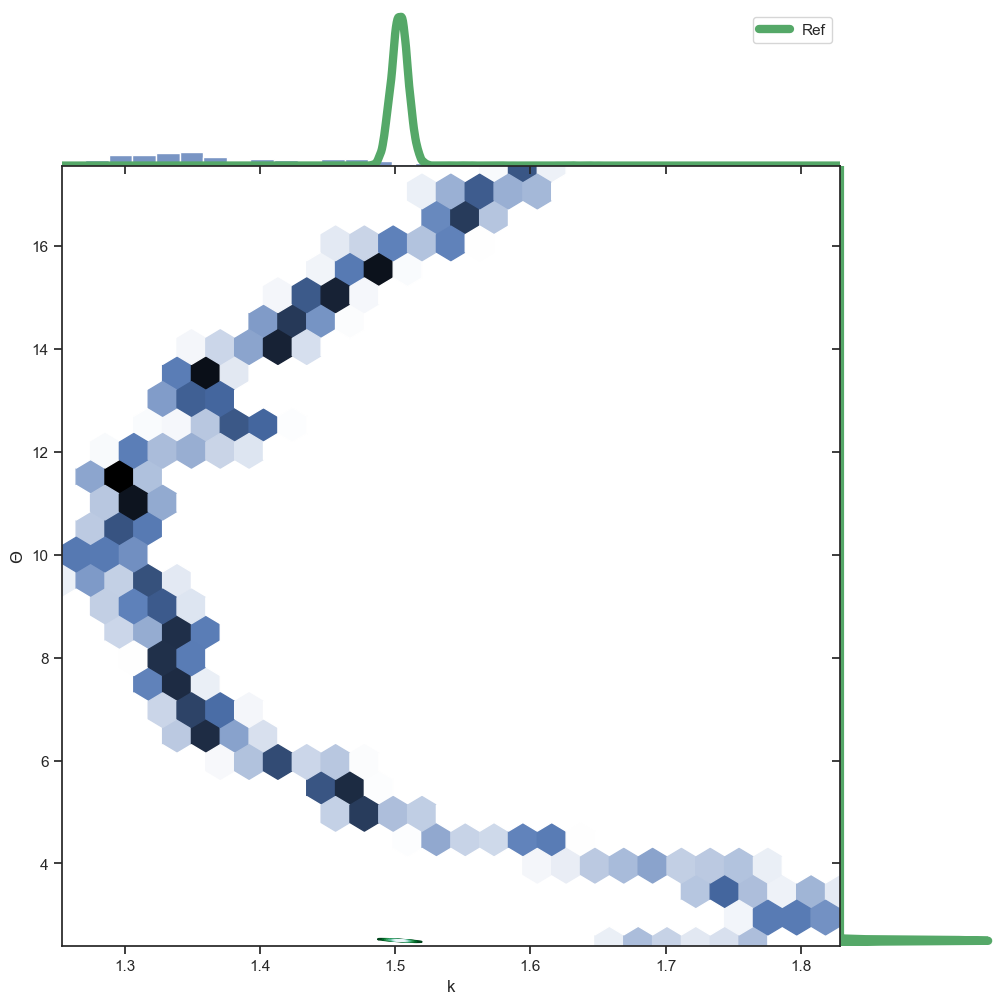

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


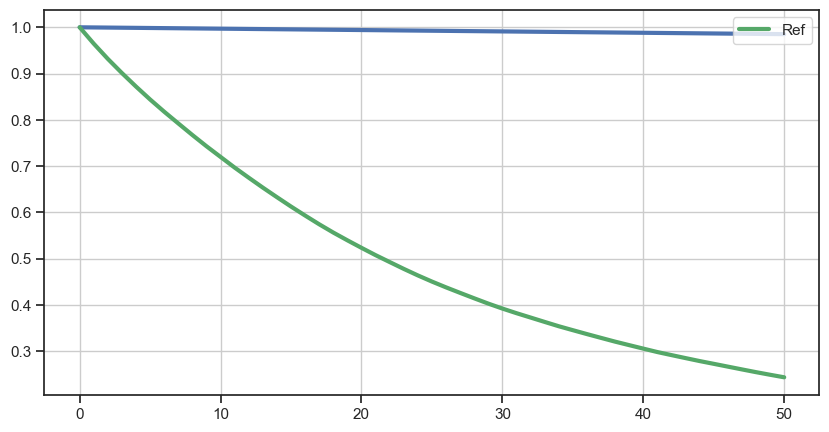

Median= 100000.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plots saved


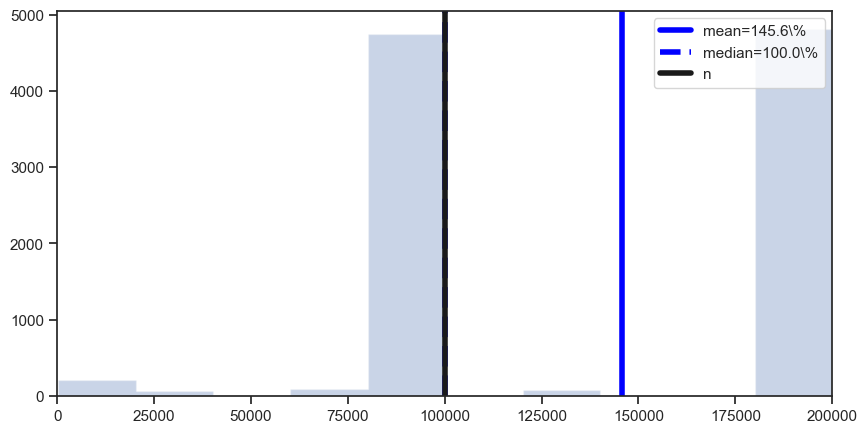

In [26]:
plotResults(S_BP, ns_BP, algoName="confidenceProxy", boolSave=1)

# Vanilla MH on wind speed data

In [27]:
x = x2

Iteration 0 Acceptance 1.0
Iteration 5000 Acceptance 0.505898820235953
Iteration 10000 Acceptance 0.5081491850814955
Iteration 15000 Acceptance 0.5026331577894791
Iteration 20000 Acceptance 0.503474826258687
Iteration 25000 Acceptance 0.5021399144034258
Iteration 30000 Acceptance 0.502383253891539
Iteration 35000 Acceptance 0.5020427987771813
Iteration 40000 Acceptance 0.5014124646883867
Iteration 45000 Acceptance 0.502499944445684


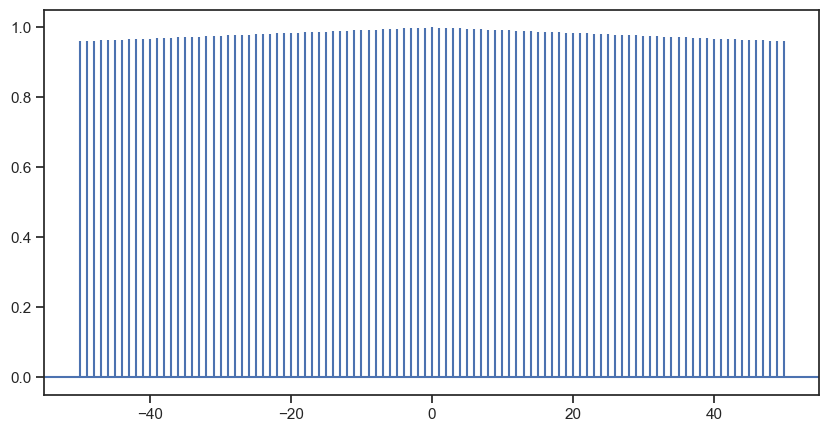

In [28]:
# Compute good marginals using a long run for later comparisons
S_ref = vanillaMHGamma(50000)
marg0 = sps.gaussian_kde(S_ref[:,0])
marg1 = sps.gaussian_kde(S_ref[:,1])
c = plt.acorr(S_ref[:,1], maxlags=50, detrend=detrend_mean, normed=True);
c_ref = c[1][c[0]>=0]
plt.show()

In [29]:
S = vanillaMHGamma(10000)

Iteration 0 Acceptance 0.0
Iteration 1000 Acceptance 0.5084915084915079
Iteration 2000 Acceptance 0.5347326336831585
Iteration 3000 Acceptance 0.5751416194601803
Iteration 4000 Acceptance 0.6038490377405658
Iteration 5000 Acceptance 0.6212757448510323
Iteration 6000 Acceptance 0.6352274620896536
Iteration 7000 Acceptance 0.6500499928581639
Iteration 8000 Acceptance 0.6551681039870023
Iteration 9000 Acceptance 0.6637040328852362


xlims = 0.930245525657746 1.6547725048729045


C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mrobi\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjus

chain_vanillaMH_basic.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


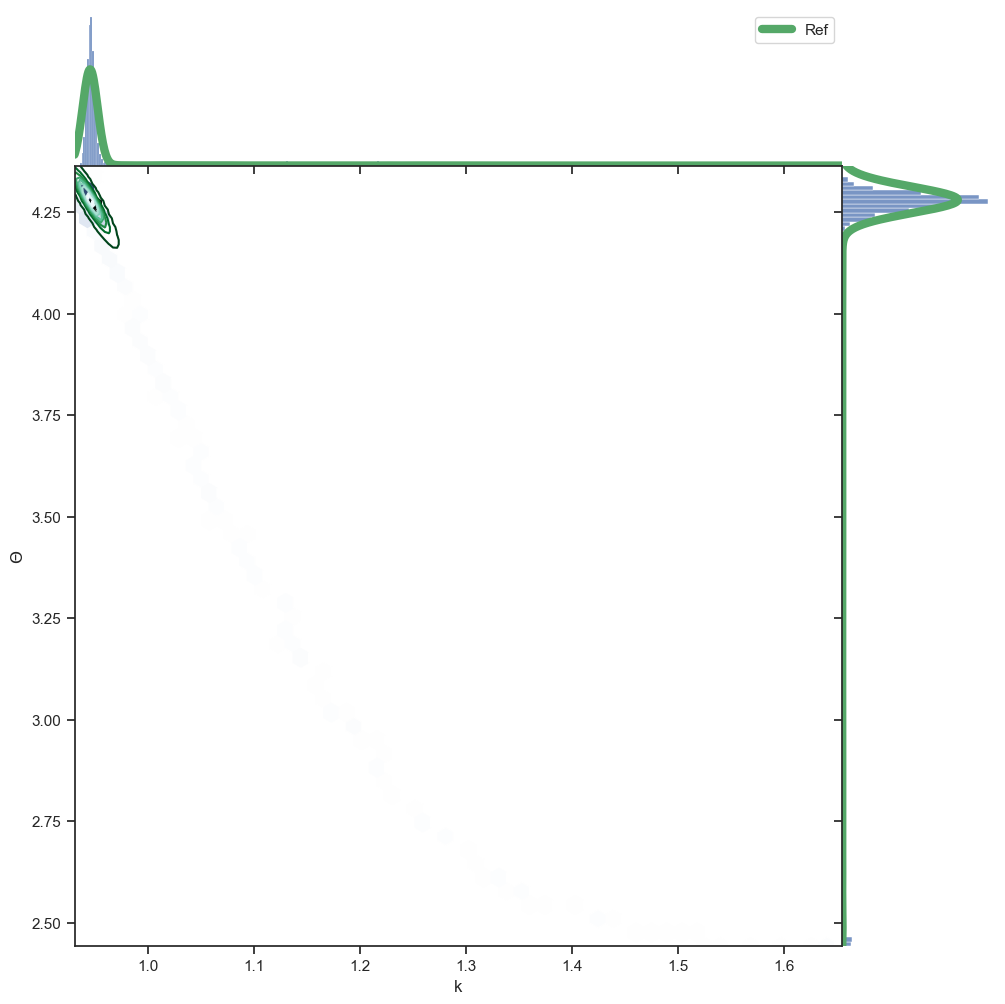

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


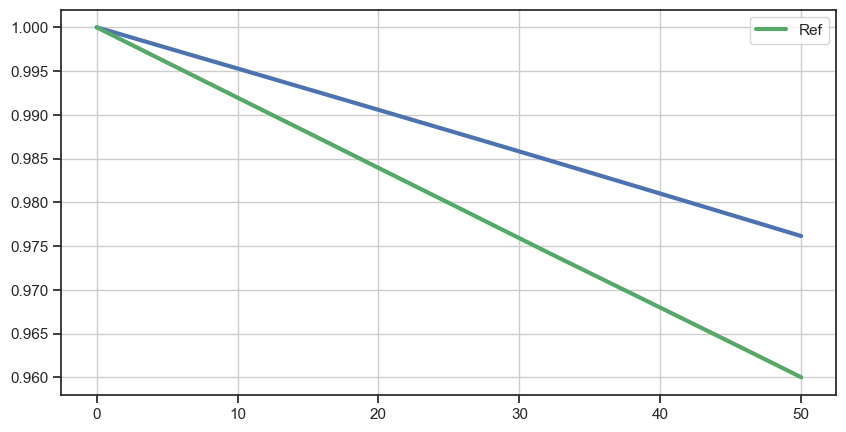

In [30]:
plotResults(S, [], algoName="vanillaMH", boolSave=1)